In [1]:
# %autoreload 2

import sys,os,glob
print('Python version:',sys.version)
print('Conda environment:',os.environ['CONDA_DEFAULT_ENV'])
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.lines import Line2D

# from mpl_toolkits.basemap import Basemap
import xarray as xr
print("version of xarray:",xr.__version__)
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))
import pickle
from pprint import pprint

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
repodir = workdir
while os.path.basename(repodir) != 'Fildier2020':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from thermoFunctions import *
from statisticalDistributions import *
from scalingApproximations import *
from slicingAndSubsetting import *
from plot1DInvLog import *
from dataFormat import *
from importingData import *
from savingResults import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
Conda environment: pyLMD
version of xarray: 0.15.0
repo: /Users/bfildier/Code/analyses/Fildier2020
Own modules available: ['plot2D', 'dataFormat', 'slicingAndSubsetting', 'conditionalstats', 'thermoFunctions', 'thermoFunctionsForMoistAdiabat', 'thermoConstants', 'savingResults', 'setEnv', 'importingData', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'plot1DInvLog', 'statisticalDistributions']


In [2]:
archivedir = '/Users/bfildier/Data/simulations/SAM6.10.10_EDMF/'
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

if not os.path.exists(figuredir): os.makedirs(figuredir)

In [3]:
simname_patterns = 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d-b150-sfcagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d-b150-sfcdisagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r%d-b100-radagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r%d',\

realiz = {300:[1,1,1,1,1],302:[2,2,2,2,2],304:[1,1,1,1,1],306:[1,1,1,1,1],308:[2,1,1,1,1]}

simtypes = 'simOref','simFO','simFD','simQO','simDref'

simtype_labels = r'$\mathcal{O}_{ref}$',\
r'$\mathcal{O}(F_{\mathcal{O}_{ref}})$',\
r'$\mathcal{O}(F_{\mathcal{D}_{ref}})$',\
r'$\mathcal{D}(Q_{\mathcal{O}_{ref}})$',\
r'$\mathcal{D}_{ref}$',\

simtype_linetype = '--',':','-.','-','-'
simtype_markers = 'o','^','s','x','o'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

SSTs = 300,302,304,306,308
lt_SSTs = 'dotted',(0, (3, 5, 1, 5, 1, 5)),'dashdot','solid','dashed'

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

n_SSTs = len(SSTs)
n_sims = len(simname_patterns)

dt = 15 # s

vars4moist_profiles = ['LWD','LWU','QN','QP','QRAD','QV','TABS','W']

ndays = 50

In [4]:
def getExpname(simname):
    return simname.split('_')[-1]
def getSimroot(simname):
    return '_'.join(simname.split('_')[:-1])

In [389]:
print("Initialize stats for each simulation")

perc_ILQ_pr = {}
cdf_invlog_ILQ_pr = {}
err_perc_ILQ_pr = {}
ranks_ILQ_pr = {}
# ds_STAT = {}
# ds_2D = {}
# moist_profiles = {}
# dry_profiles = {}
# wholeDomain_profiles = {}
# areafrac_moist = {}
prQ_prof_conditionals = {}
# epsFT = {}
data_mean_t = {}
pr_mean = {}
p_profile = {}

# new cleaner data
distributions = {}
mean_pr = {}
cdist_w = {}
cdist_tabs = {}
cdist_qv = {}
scaling = {}

i_w24 = 5 # storage index for statistics computed over 24 time slices for rainfall pdfs

Initialize stats for each simulation


In [390]:
z_coord = xr.open_dataset(os.path.join(resultdir,'z.nc'),decode_cf=False).z

In [391]:
print("Import stats for each simulation")

load2D = False

for SST in SSTs:
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        print(simname)

        # Define result folder
        expname = getExpname(simname)
        simroot = getSimroot(simname)
        resultsubdir = os.path.join(resultdir,simroot,expname)

        if not os.path.exists(resultsubdir):
            print('  skipped')
            continue

        # import precipitation statistics

        # statistical distribution
        distrib_file = os.path.join(resultsubdir,'stats_50days','dist_pr_IL.pickle')
        distributions[simname] = pickle.load(open(distrib_file,'rb'))

        # Mean rain
        mean_pr_file = os.path.join(resultsubdir,'stats_50days','mean_pr.pickle')
        mean_pr[simname] = pickle.load(open(mean_pr_file,'rb'))

        ranks = distributions[simname].ranks
        
#         if 'stats_50days' in [x[0].split('/')[-1] for x in os.walk(resultsubdir)] and \
#         os.path.isfile(os.path.join(resultsubdir,'stats_50days','scaling.pickle'):
        if os.path.isfile(os.path.join(resultsubdir,'stats_50days','scaling.pickle')):
            # conditional distributions
            cdist_w_file = os.path.join(resultsubdir,'stats_50days','cdist_w_on_pr_IL.pickle')
            cdist_w[simname] = pickle.load(open(cdist_w_file,'rb'))
            cdist_tabs_file = os.path.join(resultsubdir,'stats_50days','cdist_tabs_on_pr_IL.pickle')
            cdist_tabs[simname] = pickle.load(open(cdist_tabs_file,'rb'))
            cdist_qv_file = os.path.join(resultsubdir,'stats_50days','cdist_qv_on_pr_IL.pickle')
            cdist_qv[simname] = pickle.load(open(cdist_qv_file,'rb'))
            scaling_file = os.path.join(resultsubdir,'stats_50days','scaling.pickle')
            scaling[simname] = pickle.load(open(scaling_file,'rb'))

            
#--- old code
            
#         # Import precipitation statistics
# #         if not (SST == 306 and i_sim in (1,2,3)):

#         perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'mean_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         cdf_invlog_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'mean_cdf_invlog_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         err_perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                              'std_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
#         ranks_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                              'xy_stats_over_time',
#                                                               'ranks_ILQ_pr.pickle'),'rb'))
#         ranks = list(ranks_ILQ_pr[simname].values())[0]

# #         # Mean rain
        data_mean_t[simname] = xr.open_dataset(os.path.join(resultsubdir,'data_mean.nc'))
        pr_mean[simname] = float(np.mean(data_mean_t[simname].Prec[-ndays*24:]))

        # Import conditional averages
        if simname not in prQ_prof_conditionals.keys() and \
        'dynamic_thermo_contributions' in [x[0].split('/')[-1] for x in os.walk(resultsubdir)]:
            prQ_prof_conditionals[simname] = {}

#             prQ_prof_conditionals[simname]['QV'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'qv_prof_FTscaling_prQ.pickle'),'rb'))
#             prQ_prof_conditionals[simname]['W'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'w_prof_FTscaling_prQ.pickle'),'rb'))
#             prQ_prof_conditionals[simname]['TABS'] = \
#                         pickle.load(open(os.path.join(resultsubdir,
#                                                       'dynamic_thermo_contributions',
#                                                       'tabs_prof_FTscaling_prQ.pickle'),'rb'))

            p_profile[simname] = \
                        pickle.load(open(os.path.join(resultsubdir,
                                                      'dynamic_thermo_contributions',
                                                      'p_prof_FTscaling.pickle'),'rb'))

Import stats for each simulation
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-

In [167]:
# Import scaling and fractional changes

# cross_scaling_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'cross_scaling_for_fracchange_prQ_and_contributions.pickle'),'rb'))
# frac_change_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'fractionalChanges_prQ_and_contributions.pickle'),'rb'))
# frac_change_fullDec_ILQ_pr = pickle.load(open(os.path.join(resultdir,
#                                               'dynamic_thermo_contributions',
#                                               'fractionalChanges_prQ_and_contributions_fullDec.pickle'),'rb'))

Qmax = 99.999
Qref = 99.9
iQmax = indexOfRank(Qmax,ranks)
iQ999 = indexOfRank(99.9,ranks)
iQ9999 = indexOfRank(99.99,ranks)
iQ99999 = indexOfRank(99.999,ranks)
iQref = indexOfRank(Qref,ranks)

sQ = slice(0,iQmax)
sQ9999 = slice(0,iQ9999+1)
sQ99999 = slice(0,iQ99999+1)
ranks_ref = ranks[sQ]
ranks_9999 = ranks[sQ9999]
ranks_99999 = ranks[sQ99999]


sQext = slice(iQ999,iQ9999)

In [9]:
print('Fractional changes in rainfall intensities and exceedance amounts')

# Compute fractional changes
fracchange_camountIL = {}
fracchange_percIL = {}

SST_pairs = (300,302),\
            (302,304),\
            (304,306),\
            (306,308),\
            (300,304),\
            (302,306)

for SST_pair in SST_pairs:
    print(SST_pair)
    
    SST_cold = SST_pair[0]
    SST_warm = SST_pair[1]
    dT = SST_warm-SST_cold
    
    for i_sim in range(n_sims):

        simname_cold = simname_patterns[i_sim]%(SST_cold,realiz[SST_cold][i_sim])
        simname_warm = simname_patterns[i_sim]%(SST_warm,realiz[SST_warm][i_sim])
        
        if not simname_cold in distributions.keys():
            print("no CDF_IL data for",simname_cold)
            continue
        if not simname_warm in distributions.keys():
            print("no CDF_IL data for",simname_warm)
            continue
        
        key = "%s_%s"%(simname_cold,simname_warm)

        fracchange_camountIL[key] = np.nan*np.zeros((iQmax,))
        fracchange_percIL[key] = np.nan*np.zeros((iQmax,))
        for iQ in range(iQmax):
            
#             cdf_invlog_cold = pr_mean[simname_cold]*cdf_invlog_ILQ_pr[simname_cold]
#             cdf_invlog_warm = pr_mean[simname_warm]*cdf_invlog_ILQ_pr[simname_warm]
            cdf_invlog_cold = mean_pr[simname_cold]*distributions[simname_cold].invCDF
            cdf_invlog_warm = mean_pr[simname_warm]*distributions[simname_warm].invCDF
            
            perc_cold = distributions[simname_cold].percentiles
            perc_warm = distributions[simname_warm].percentiles
            
            if cdf_invlog_cold[iQ] != 0:
                fracchange_camountIL[key][iQ] = (cdf_invlog_warm[iQ]/\
                                                 cdf_invlog_cold[iQ]-1)/dT*100
            if perc_cold[iQ] != 0:
                fracchange_percIL[key][iQ] = (perc_warm[iQ]/\
                                              perc_cold[iQ]-1)/dT*100

Fractional changes in rainfall intensities and exceedance amounts
(300, 302)
(302, 304)
(304, 306)
(306, 308)
(300, 304)
(302, 306)


# Main figures

## Figure 3 (redo) - distributions

RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1


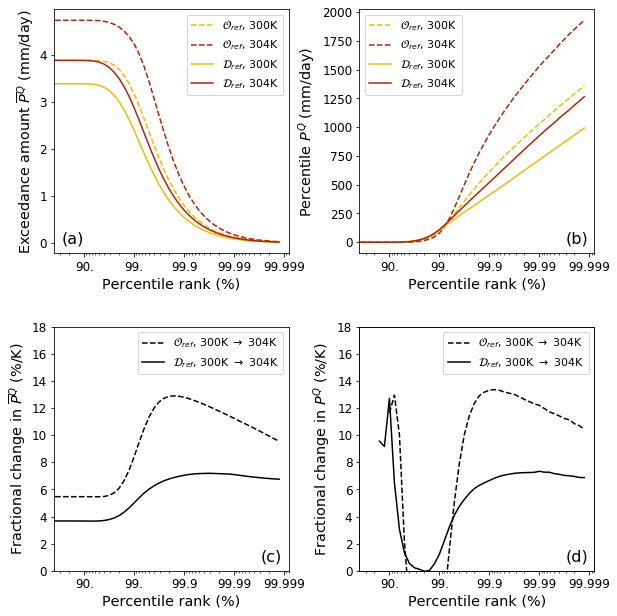

In [84]:
lt = ['--','-']

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

SST_inds = (0,2)
# SST_inds = (1,3)
SSTs2plot = SSTs[SST_inds[0]],SSTs[SST_inds[1]]
sim_inds = np.array((0,4))

# ranks2show = ranks_9999
# sQ2show = sQ9999
ranks2show = ranks_99999
sQ2show = sQ99999
iQshow_max = 99.999
    
for i_sim in sim_inds:
    
    for i_SST in SST_inds:
        
        SST = SSTs[i_SST]
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simlab = simtype_labels[i_sim]+', %dK'%SST
        print(simname)

#         cdf_invlog = pr_mean[simname]*cdf_invlog_ILQ_pr[simname]
        invCDF_show = mean_pr[simname]*distributions[simname].invCDF[sQ2show]
        perc_show = distributions[simname].percentiles[sQ2show]

        # panel (a)
        subplotRanksILog(axs[0,0],ranks2show,
                         invCDF_show,
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)
        
        # panel (b)
        subplotRanksILog(axs[0,1],ranks2show,
                         perc_show,
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)


    key = "%s_%s"%(simname_patterns[i_sim]%(SSTs2plot[0],realiz[SSTs2plot[0]][i_sim]),
                   simname_patterns[i_sim]%(SSTs2plot[1],realiz[SSTs2plot[1]][i_sim]))
    keylabel = simtype_labels[i_sim]+r", %dK $\rightarrow$ %dK"%tuple(SSTs2plot)

    # panel (c)
    subplotRanksILog(axs[1,0],ranks2show,
                     fracchange_camountIL[key][sQ2show],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)
    
    # panel (d)
    subplotRanksILog(axs[1,1],ranks2show,
                     fracchange_percIL[key][sQ2show],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)


x = np.flipud(1./(1-ranks2show/100.))
# Deal with np.nans at the beginning of panel (d)
addYLine(axs[1,1],x,y0=-35)

for ax in axs.flatten():
    # add legend
    ax.legend(fontsize=11)
    # add x labels
    ax.set_xlabel('Percentile rank (%)')
#     # transform x axis
#     transformXaxisIL(ax,x,offset=0)
#     # crop axis
#     iQ_min = 4
# #     iQ_min = 14
#     ax.set_xlim((x[iQ_min-1],0.8))

    ax.invert_xaxis()
    iQ_min = 4
    ax.set_xlim((x[iQ_min-1],0.8))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    n = ceil(log10(x.max()))
    offset = 1
    N = len(labels)
    for i in range(1,N):
        labels[-n+i-4+offset] = ("%2.7f"%(100*(1-10**(-n+i-1)))).rstrip('0')
        if -n+i-1 == 0:
            break
    ax.set_xticklabels(labels)

    
axs[0,0].set_ylabel(r'Exceedance amount $\overline{P}^Q$ (mm/day)')
axs[0,1].set_ylabel(r'Percentile $P^Q$ (mm/day)')
axs[1,0].set_ylabel(r'Fractional change in $\overline{P}^Q$ (%/K)')
axs[1,1].set_ylabel(r'Fractional change in $P^Q$ (%/K)')

axs[1,0].set_ylim((0,18))
axs[1,1].set_ylim((0,18))

##-- Panel numbers
axs[0,0].text(0.03,0.04,'(a)',transform = axs[0,0].transAxes,fontsize=16)
axs[0,1].text(0.88,0.04,'(b)',transform = axs[0,1].transAxes,fontsize=16)
axs[1,0].text(0.88,0.04,'(c)',transform = axs[1,0].transAxes,fontsize=16)
axs[1,1].text(0.88,0.04,'(d)',transform = axs[1,1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'all','Figure3_distributions_org_disorg_%d_%d.pdf'%tuple(SSTs2plot)),
                bbox_inches='tight')

plt.show()

## Figure 4 (new) - Pext vs. Pmean

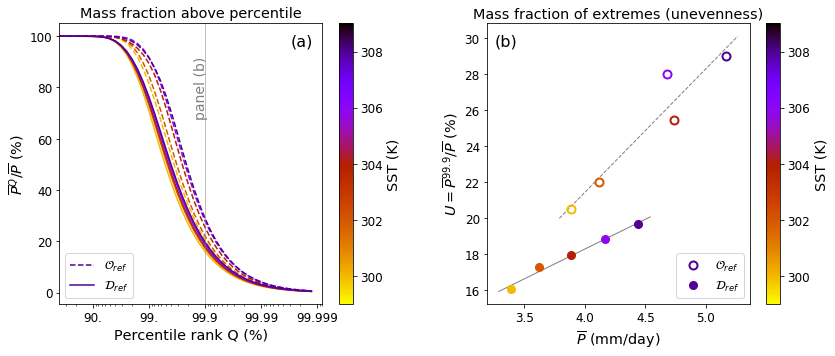

In [84]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

iQ2show = iQref
# iQ2show = iQ9999

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

##--- panel (a) normalized exceedance amounts (mass fraction of extremes)

ax = axs[0]

for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in (0,4):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
#         norm_cdf_IL_prQ = cdf_invlog_ILQ_pr[simname]*100
        invCDF_show = distributions[simname].invCDF[sQ2show]*100
        
        # Define legend label
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        else:
            lab = ''

        subplotRanksILog(ax,ranks2show,
                         invCDF_show,
                         col=SST_col[i_SST],
                         labels=lab,
                         ltype=simtype_linetype[i_sim],
                         transformX=False)
        
# Line for correspondence with panel (b)
x = np.flipud(1./(1-ranks2show/100.))
ax.axvline(x=x[iQ2show],ymin=-2,ymax=102,linewidth=0.5,c='gray')
ax.text(x[iQ2show-2], 80, 'panel (b)', rotation=90, va='center',fontsize=14,c='grey')

# Panel number
# ax.text(x[iQref+7],0.9,'(a)',transform = ax.transAxes,fontsize=16)

# add x labels
ax.set_xlabel('Percentile rank Q (%)')
# transform x axis
transformXaxisIL(ax,x)
# crop axis
iQ_min = 4
ax.set_xlim((x[iQ_min-1],0.8))
    
# ax.set_ylabel(r'Extreme precipitation $P^{99.9-99.99}$ (mm/day)')
ax.set_ylabel(r'$\overline{P}^{Q}/\overline{P}$ (%)')
ax.set_title('Mass fraction above percentile')
ax.legend(loc='lower left',fontsize=12)

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cax.set_ylabel('SST (K)')


##--- panel (b) unevenness for Oref and Dref

ax = axs[1]
x_all = []
y_all = []
    
#     for i_sim in range(n_sims):
for i_sim in (0,4):

#     x_all.append([])
#     y_all.append([])
    
    x = [mean_pr[simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])] for i_SST in range(n_SSTs)]
    y = [distributions[simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])].invCDF[iQ2show]*100 for i_SST in range(n_SSTs)]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    x_line = np.linspace(x[0]-0.1,x[-1]+0.1)
    y_line = intercept + x_line*slope
    ax.plot(x_line,y_line,c='k',linestyle=simtype_linetype[i_sim],linewidth=1,alpha=0.5)
    

    for i_SST in range(n_SSTs):
        
        SST = SSTs[i_SST]
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in distributions.keys():
#             print("%dK, %s:"%(SST,simtype_labels[i_sim]),perc_ILQ_pr[simname][iQref])
#             x,y = SST,perc_ILQ_pr[simname][iQmax]
            # Mean over percentiles
#             x = pr_mean[simname]
            x = mean_pr[simname]
#             y = np.mean(perc_ILQ_pr[simname][sQext])
            y = distributions[simname].invCDF[iQ2show]*100
#             # store
#             x_all[-1].append(x)
#             y_all[-1].append(y)

            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)
    
# lt = ['--','-']
# for i in range(2):
    
#     x,y = x_all[i], y_all[i]
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     x_line = np.linspace(x[0]-0.1,x[-1]+0.1)
#     y_line = intercept + x_line*slope
#     ax.plot(x_line,y_line,c='k',linestyle=lt[i],linewidth=1,alpha=0.5)

ax.set_xlabel(r'$\overline{P}$ (mm/day)')
# ax.set_ylabel(r'Extreme precipitation $P^{99.9-99.99}$ (mm/day)')
ax.set_ylabel(r'$U = \overline{P}^{99.9}/\overline{P}$ (%)')
ax.set_title('Mass fraction of extremes (unevenness)')
ax.legend(fontsize=12,loc='lower right')

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
cax.set_ylabel('SST (K)')


##-- Panel numbers
axs[0].text(0.88,0.92,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.03,0.92,'(b)',transform = axs[1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'paper','Figure4.pdf'),
                bbox_inches='tight')
plt.show()

In [85]:
simname

'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1'

In [104]:
print('contribution of the circulation to the unevenness')

U_Oref = {}
U_Dref = {}
dU = {}
for SST in (300,302,304):
    
    simname_Oref = simname_patterns[0]%(SST,realiz[SST][i_sim])
    simname_Dref = simname_patterns[4]%(SST+4,realiz[SST+4][i_sim])
    
    U_Oref[SST] = distributions[simname_Oref].invCDF[iQ2show]
    U_Dref[SST+4] = distributions[simname_Dref].invCDF[iQ2show]
    dU[SST] = (U_Oref[SST] / U_Dref[SST+4] - 1)*100

    print('SST = %d, dU = %2.1f %%'%(SST,dU[SST]))
    
print()
print('contribution of the circulation to the fractional change in unevenness')
d_frac_U_300 = ((U_Oref[302]/U_Oref[300]-1)/2 - (U_Dref[306]/U_Dref[304]-1)/2)*100
print('%2.2f %%/K'%d_frac_U_300)

contribution of the circulation to the unevenness
SST = 300, dU = 14.4 %
SST = 302, dU = 16.8 %
SST = 304, dU = 29.3 %

contribution of the circulation to the fractional change in unevenness
1.11 %/K


In [101]:
U_Dref

{304: 0.17919588088989258, 306: 0.18824662268161774, 308: 0.19657619297504425}

(0.03636388354856357, 0.025253766288541035)

## Figure 5

In [13]:
print('Linearly regressed fractional changes in rainfall intensities and exceedance amounts')

sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

fracchange_mean_camountIL = {}
fracchange_mean_percIL = {}
fracchange_mean_prmean = {}
offset_camountIL = {}
offset_percIL = {}
offset_prmean = {}

# for i_sim in range(n_sims):
for i_sim in (0,4):
    
    key = simtypes[i_sim]
    print(' .  ',key)
    
    fracchange_mean_camountIL[key] = np.nan*np.zeros((iQmax,))
    offset_camountIL[key] = np.nan*np.zeros((iQmax,))
    fracchange_mean_percIL[key] = np.nan*np.zeros((iQmax,))
    offset_percIL[key] = np.nan*np.zeros((iQmax,))
        
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        
#         if (i_SST,i_sim) in sims2exclude:
            
#             print(simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim]),'excluded')
            
        
        if not (i_SST,i_sim) in sims2exclude:

            sst_values.append(SSTs[i_SST])
    
    # For each percentile, do the calculation
    for iQ in range(iQmax):        
    
        percIL_values = []
        camountIL_values = []

        # For each SST, store precip data
        for SST in sst_values:
            
            simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
            
#             camountIL_values.append(pr_mean[simname]*cdf_invlog_ILQ_pr[simname][iQ])
#             percIL_values.append(perc_ILQ_pr[simname][iQ])
            camountIL_values.append(mean_pr[simname]*distributions[simname].invCDF[iQ])
            percIL_values.append(distributions[simname].percentiles[iQ])

        # Regress ln(pr) against T for percentiles
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(percIL_values))
        fracchange_mean_percIL[key][iQ] = slope
        offset_percIL[key][iQ] = intercept
        # Regress ln(pr) against T for rain amounts
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(camountIL_values))
        fracchange_mean_camountIL[key][iQ] = slope
        offset_camountIL[key][iQ] = intercept
    
    prmean_values = []
    # For each SST, store precip data
    for SST in sst_values:
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
#         prmean_values.append(pr_mean[simname])
        prmean_values.append(mean_pr[simname])

    # Regress ln(pr) against T for mean rain 
    slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(prmean_values))
    fracchange_mean_prmean[key] = slope
    offset_prmean[key] = intercept
        


Linearly regressed fractional changes in rainfall intensities and exceedance amounts
 .   simOref
 .   simDref


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
[1548.26275787 1967.51723774]
[1018.83439584 1181.30596293 1303.84777124 1485.14076736 1668.33245325]
0.05893
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
0.05893
0.05805
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
0.05805
0.05719
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
0.05719
0.05634
0.05634
0.05551
0.05551


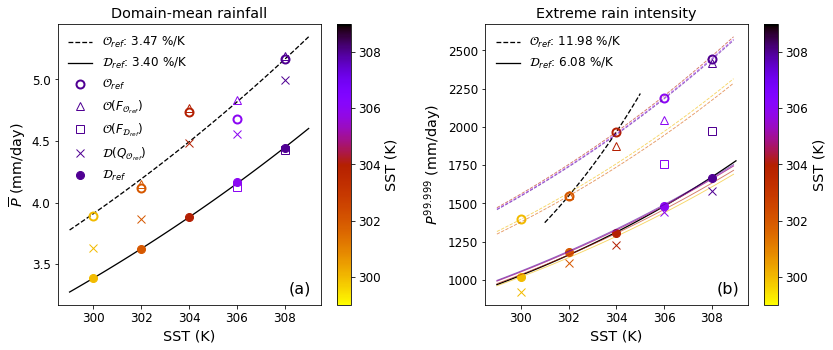

In [143]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# iQext = iQref + 10
iQext = iQref + 20

def getExponentialSSTCurve(i_sim,slopes,offsets,iQ=None):

    simtype = simtypes[i_sim]
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:
            sst_values.append(SSTs[i_SST])
    sst_values = np.array(sst_values)
    # curve points
    x = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
    if iQ is None:
        y = np.exp(slopes[simtype]*x + offsets[simtype])
    else:
        y = np.exp(slopes[simtype][iQ]*x + offsets[simtype][iQ])
    
    return x,y
    
# legend font size
ftsize = 12
# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)


fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

##---- Panel (a): mean P
ax = axs[0]
# ax.set_ylim((3.2,5.9))

##--- Draw exponential fits
for i_sim in range(n_sims):

    if i_sim in (0,4):

        simtype = simtypes[i_sim]

#         x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_prmean,offset_prmean)

        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])
                
                # extreme P
#                 pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
#                 pr_values.append(np.mean(distributions[simname].percentiles[sQext]))
                # 99.9th percentile
                pr_values.append(mean_pr[simname])
                
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        
        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

#         lab = 'Exponential fit, '+simtype_labels[i_sim]+'%2.2f'%(fracchange_mean_prmean[simtype]*100)+'%/K'
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
#         lab = simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
#         ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]

    for i_sim in range(n_sims):

        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue

        if simname in mean_pr.keys():

#             x,y = SST,pr_mean[simname]
            x,y = SST,mean_pr[simname]
            
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

ax.legend(fontsize=ftsize,framealpha=0)

##---- Panel (b): extreme P ----##
ax = axs[1]
# ax.set_ylim((450,1850))

##--- Draw exponential fits
for i_sim in range(n_sims):

    simtype = simtypes[i_sim]

    if i_sim in (0,4):
#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
#             if not (i_SST,i_sim) in sims2exclude:
            if i_sim == 4 or i_SST in (1,2):
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])
                
                # extreme P
#                 pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
#                 pr_values.append(np.mean(distributions[simname].percentiles[sQext]))
                # 99.9th percentile
                pr_values.append(distributions[simname].percentiles[iQext])
                
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        print(pr_values)

        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

        
##--- Draw points and CC curves
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in distributions.keys():

            # Mean over percentiles
#             x,y = SST,np.mean(perc_ILQ_pr[simname][sQext])
#             x,y = SST,np.mean(distributions[simname].percentiles[sQext])
            # Reference 99.9th percentile
#             x,y = SST,perc_ILQ_pr[simname][iQref]
            x,y = SST,distributions[simname].percentiles[iQext]
            
#             #--- Draw error bar
#             if i_sim in (0,4):
#                 y1 = distributions[simname].percentiles_Q1[iQext]
#                 y2 = distributions[simname].percentiles_Q3[iQext]
#                 ax.plot([x,x],[y1,y2],c=SST_col[i_SST])
        
            #--- Draw CC curve
            if i_sim in (0,4):
                # Assuming a fixed rate
    #             y_vals = y_vals_norm*y*np.exp(-rate*x)

                # Assuming the CC formula
                i_x = np.argmin(np.abs(x_vals - float(SST)))
                y_vals = y_vals_ref/y_vals_ref[i_x]*y
                print("%2.5f"%((np.diff(y_vals)[i_x]/y_vals[i_x])/dT))

                ax.plot(x_vals,y_vals,linestyle=simtype_linetype[i_sim],\
                        c=SST_col[i_SST],linewidth=0.9,alpha=0.6)
                
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
#                 lab = simtype_labels[i_sim]
                lab = ''
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

for ax in axs:
    
    ax.set_xlabel('SST (K)')
    
    # Color bar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

axs[0].set_ylabel(r'$\overline{P}$ (mm/day)')
# axs[1].set_ylabel(r'99.9th percentile $P^{99.9}$ (mm/day)')
axs[1].set_ylabel(r'$P^{%2.3f}$ (mm/day)'%ranks[iQext])

axs[0].set_title(r'Domain-mean rainfall')
axs[1].set_title(r'Extreme rain intensity')

# axs[1].legend(ncol=2,fontsize=11)
axs[1].legend(ncol=1,fontsize=ftsize,framealpha=0)

##-- Panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'all','meanP_P%s_vs_SST_allsims.pdf'%str(ranks[iQext]).replace('.','')[:5]),
                bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','Figure5.pdf'),
                bbox_inches='tight')
plt.show()

## Figure 6 (new, in section 4, replacing Table 2) - enhancement factors as a function of SST (for Pbar, Pext and dcc)

In [106]:
# Enhancement factors
ef_names = 'full','radiative feedback','mean climate shift org','surface-flux feedback','mean climate shift disorg','circulation total'
ef_labels = r'$\mathcal{E}_{\mathrm{total}}$',\
    r'$\mathcal{E}_{\mathrm{rad}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$',\
    r'$\mathcal{E}_{\mathrm{surf}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$',\
    r'$\mathcal{E}_{\mathrm{circ}}$'
ef_lon_labels = 'Total',\
                 'Radiatively-driven circulation',\
                 'Mean shift in surface fluxes',\
                 'Surface-feedback reinforced circulation',\
                 'Mean shift in radiative cooling',\
                 'Circulation + its mean climate effects'

ef_inds = (0,4),(2,4),(1,2),(0,1),(3,4),(0,3)
n_ef = len(ef_names)
ef_cols = 'k','orange','r','darkblue','steelblue','g'
# ef_markers = r'$t$',r'$r$',r'$F$',r's',r'$Q$',r'c'
ef_markers = "T","R","F","S","Q","C"

SST_ef_2exclude = (0,1),(0,2),(0,3),(1,1),(1,2)

In [392]:
print("compute values for enhancemnet factors for precipitation efficiency argument")

mean_pr_array = np.nan*np.zeros((n_SSTs,n_sims))
prQ_array = np.nan*np.zeros((n_SSTs,n_sims,len(ranks_99999)))
prQext_array = np.nan*np.zeros((n_SSTs,n_sims))
pr999_array = np.nan*np.zeros((n_SSTs,n_sims))
pr9999_array = np.nan*np.zeros((n_SSTs,n_sims))
pr99999_array = np.nan*np.zeros((n_SSTs,n_sims))

###--- Fixed climate quantities

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

        # mean of extremes
#         prQ = np.nanmean(perc_ILQ_pr[simname][sQext])
#         prQ_array[i_SST,i_sim] = prQ
        mean_pr_array[i_SST,i_sim] = mean_pr[simname]
        prQext_array[i_SST,i_sim] = np.mean(distributions[simname].percentiles[sQext])
        prQ_array[i_SST,i_sim] = distributions[simname].percentiles[sQ99999]
        pr999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ999]
        pr9999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ9999]
        pr99999_array[i_SST,i_sim] = distributions[simname].percentiles[iQ99999]

        
###--- Fractional change quantities

# automate
def deltaFracChange(var_array):

    NSST, Nsims = var_array.shape

    fc_array = np.log(var_array[1:,:]/var_array[:NSST-1,:])/2*100
    delta_fc_array = np.zeros((NSST-1,Nsims-1))
    for j in range(Nsims-1):
        delta_fc_array[:,j] = fc_array[:,j] - fc_array[:,-1]

    return delta_fc_array

# compute enhancement of each component in comparison with Dref
for key in 'prQext_array',:
    
    array = getattr(thismodule,key)
    NSST, Nsims = array.shape
    norm_array = np.nan*np.zeros((NSST,Nsims-1))
    for i_sim in range(Nsims-1):
        norm_array[:,i_sim] = array[:,i_sim]/array[:,-1]
    setattr(thismodule,"norm_%s"%key,norm_array)

# compute difference in fractional changes in each component with Dref
delta_mean_pr_array = deltaFracChange(mean_pr_array)
delta_prQext_array = deltaFracChange(prQext_array)
delta_pr999_array = deltaFracChange(pr999_array)
delta_pr9999_array = deltaFracChange(pr9999_array)
delta_pr99999_array = deltaFracChange(pr99999_array)


###--- Enhancement factors

def computeEnhancementFactors(X_array):
    
    """X_arrray contains statistics in SST-simtype space"""

    # initialize
    shape = list(X_array.shape)
    shape[1] = n_ef
    ef_array = np.nan*np.zeros(shape)
    
    # compute
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_ef in range(n_ef):

            # Pass SST-EF pair to exclude
            if (i_SST,i_ef) in SST_ef_2exclude:
                continue

            # get average over extremes
            ef_array[i_SST,i_ef] = X_array[i_SST,ef_inds[i_ef][0]] / X_array[i_SST,ef_inds[i_ef][1]]

    return ef_array
    
def printEFArrayAsLatexTable(array):
    # Convert array to dataframe
    ef_df = pd.DataFrame(array)

    # Remove simulations to avoid
    for i_SST,i_ef in SST_ef_2exclude:
        ef_df.loc[i_SST,i_ef] = '-'

    # Replace row names
    row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
    ef_df = ef_df.rename(row_names,axis='index')

    # Display in latex table format
    print(ef_df.to_latex(float_format=lambda x:"%.2f"%x))
    
    
# compute enhancement of each component in comparison with Dref
for key in 'mean_pr_array','prQext_array','pr999_array','pr9999_array','pr99999_array','prQ_array':
    
    array = getattr(thismodule,key)
    ef_array = computeEnhancementFactors(array)
    setattr(thismodule,"ef_%s"%key,ef_array)
    
    print()
    print('--------------- %s -----------------'%key)
    if len(ef_array.shape) < 3:
        printEFArrayAsLatexTable(ef_array)
    


compute values for enhancemnet factors for precipitation efficiency argument

--------------- mean_pr_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.15 &    - &    - &    - & 1.07 & 1.07 \\
302 K & 1.14 &    - &    - & 0.99 & 1.07 & 1.06 \\
304 K & 1.23 & 0.99 & 1.25 & 0.99 & 1.16 & 1.06 \\
306 K & 1.12 & 0.99 & 1.17 & 0.97 & 1.09 & 1.03 \\
308 K & 1.16 & 1.00 & 1.17 & 1.00 & 1.12 & 1.03 \\
\bottomrule
\end{tabular}


--------------- prQext_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.46 &    - &    - &    - & 0.93 & 1.57 \\
302 K & 1.45 &    - &    - & 1.03 & 0.96 & 1.51 \\
304 K & 1.79 & 1.21 & 1.35 & 1.09 & 1.01 & 1.77 \\
306 K & 1.68 & 1.27 & 1.23 & 1.07 & 1.01 & 1.67 \\
308 K & 1.72 & 1.31 & 1.28 & 1.03 & 0.99 & 1.74 \\
\bottomrule
\end{tabular}


--------------- pr999_array -----------------
\begin{tabular}{lrlllrr}
\toprule

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


Show enhancement factors for all SSTs at extreme percentiles vs. SST


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide


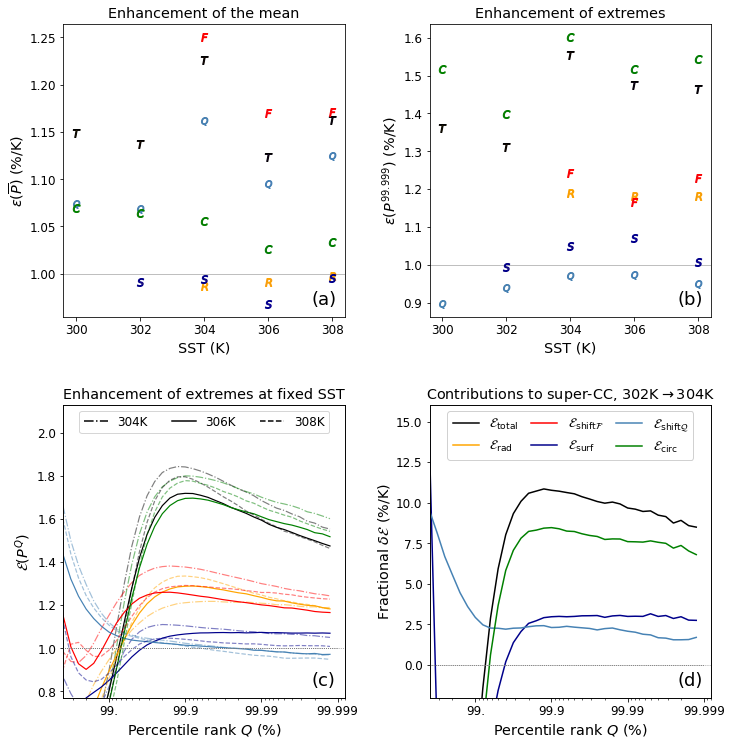

In [393]:

print("Show enhancement factors for all SSTs at extreme percentiles vs. SST")


# ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','prQ']]
# labels = ['\overline{P}','P^Q']

ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','pr99999']]
labels = ['\overline{P}','P^{99.999}']
ext_lab = 'pr99999'

dSST = 2

fig,axs_all = plt.subplots(ncols=2,nrows=2,figsize=(12,12))


###----------- TOP ------------###

axs = axs_all[0]

for ax,ef2show,lab in zip(axs,ef2show_all,labels):
    
    # horizontal y=1 lines
    ax.axhline(y=1,c='grey',linewidth=0.5)

    for i_SST in range(5):

        SST = SSTs[i_SST]

        Nc = 0

        for i_ef in range(n_ef):

            Nc += 1 # Count to reverse x axis once reach last curve

    #         if (i_SST,ef_inds[i_ef][0]) in sims2exclude:
    #             print("passing %s"%simname)
    # #             print(' passing')
    #             continue

            col = SST_col[i_SST]

            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            col = ef_cols[i_ef]
            mw = 1
#             if i_sim == 0:
#                 mw = 2

            # x
            x = SST

            # y
            y = ef2show[i_SST,i_ef]

            ax.plot(x,y,marker="$ {} $".format(ef_markers[i_ef]), ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)



    # ax.legend(loc='lower left',fontsize=11)
    ax.set_xlabel('SST (K)')
    ax.set_ylabel(r'$\varepsilon (%s)$ (%%/K)'%lab)
    ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

    
axs[0].set_title("Enhancement of the mean")
axs[1].set_title("Enhancement of extremes")

##-- panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=18)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=18)



###------------- BOTTOM ------------###
axs = axs_all[1]

sQ = sQ99999
    
##-- Panel (c): Plot enhancement factors at fixed SST
ax = axs[0]

ax.set_ylim((0.77,2.13))

x = np.flipud(1./(1-ranks[sQ]/100.))
addYLine(ax,x,y0=1,lt=':',transformX=False)
# addZeroLine(ax,x,alpha=0)

h_all = [] # for legend

for i_SST in (2,3,4):

    for i_ef in range(n_ef):

    #     lab = simtype_labels[ef_inds[i_ef][0]][:-1]+"/%s"%simtype_labels[ef_inds[i_ef][1]][1:]
    #     efs = enhancementFactor(mean_fracchange_percIL_ef[i_ef],mean_d_intercept_percIL_ef[i_ef],SST)

        efs = ef_prQ_array[i_SST,i_ef]

        h = subplotRanksILog(ax,ranks[sQ],
                         efs[sQ],
                         col=ef_cols[i_ef],
                         ltype=lt_SSTs[i_SST],
                         linewidth=1.2,
                         alpha=1-0.5*np.absolute(3-i_SST),
                         labels='%dK'%SSTs[i_SST],
                         transformX=False)
        
        if i_ef == 0:
            h_all.append(h)

##-- Panel (d): Plot fractional change in enhancement factors (SST-independent)
ax = axs[1]
ax.set_ylim((-2.03,16.03))

x = np.flipud(1./(1-ranks[sQ]/100.))
addYLine(ax,x,y0=0,lt=':',transformX=False)

i_SST_cold = 1
dSST = 2 # K

for i_ef in range(n_ef):
    
#     lab = simtype_labels[ef_inds[i_ef][0]][:-1]+"/%s"%simtype_labels[ef_inds[i_ef][1]][1:]
    
#     d_ef = (ef_prQ_array[i_SST_cold+1,i_ef]/ef_prQ_array[i_SST_cold,i_ef]-1)/dSST*100
    d_ef = np.log(ef_prQ_array[i_SST_cold+1,i_ef]/ef_prQ_array[i_SST_cold,i_ef])/dSST*100
    
    subplotRanksILog(ax,ranks[sQ],
                     d_ef,
                     col=ef_cols[i_ef],
#                      ltype=lt[i],
                     linewidth=1.5,
                     labels=ef_labels[i_ef],
                     transformX=False)

    
for ax in axs:
    # transform x axis
    transformXaxisIL(ax,x,offset=1)
    # reduce axis
    iQ_min = 15
    ax.set_xlim((x[iQ_min-1],0.8))

    ax.set_xlabel('Percentile rank $Q$ (%)')

axs[0].set_title("Enhancement of extremes at fixed SST")
axs[1].set_title(r"Contributions to super-CC, 302K$\rightarrow$304K")
    
axs[0].set_ylabel(r'$\mathcal{E}(P^Q)$')
axs[1].set_ylabel(r'Fractional $\delta \mathcal{E}$ (%/K)')


# legend
legend_elements = [Line2D([0],[0],color='k',lw=1.5,linestyle=lt_SSTs[i_SST],label='%dK'%SSTs[i_SST]) for i_SST in (2,3,4)]
axs[0].legend(handles=legend_elements,ncol=3,loc='upper center',fontsize=12)
axs[1].legend(loc='upper center',ncol=3,framealpha=0.9,fontsize=13,columnspacing=1)

##-- panel numbers
axs[0].text(0.88,0.04,'(c)',transform = axs[0].transAxes,fontsize=18)
axs[1].text(0.88,0.04,'(d)',transform = axs[1].transAxes,fontsize=18)

    
plt.savefig(os.path.join(figuredir,'all','ef_meanP_%s_vs_SST.pdf'%ext_lab),
            bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','Figure6.pdf'),
            bbox_inches='tight')
plt.show()
    

In [177]:
print('test')
iQext = 49

simname_Oref_304 = simname_patterns[0]%(304,realiz[304][0])
simname_Oref_302 = simname_patterns[0]%(302,realiz[302][0])
simname_Dref_304 = simname_patterns[4]%(304,realiz[304][4])
simname_Dref_302 = simname_patterns[4]%(302,realiz[302][4])
print(simname_Oref_304,simname_Oref_302,simname_Dref_304,simname_Dref_302)

prQ_Oref_304 = distributions[simname_Oref_304].percentiles
prQ_Oref_302 = distributions[simname_Oref_302].percentiles
prQ_Dref_304 = distributions[simname_Dref_304].percentiles
prQ_Dref_302 = distributions[simname_Dref_302].percentiles

print(prQ_Oref_302[iQext],prQ_Oref_304[iQext],prQ_Dref_302[iQext],prQ_Dref_304[iQext])

slope, intercept, r_value, p_value, std_err = stats.linregress([302,304],np.log([prQ_Oref_302[iQext],prQ_Oref_304[iQext]]))
print(slope)
print(np.log(prQ_Oref_304[iQext]/prQ_Oref_302[iQext])/2)

fc_prQ_Oref = (np.log(prQ_Oref_304/prQ_Oref_302)/dSST*100)[iQext]
fc_prQ_Dref = (np.log(prQ_Dref_304/prQ_Dref_302)/dSST*100)[iQext]

print(fc_prQ_Oref,fc_prQ_Dref)

print(fc_prQ_Oref-fc_prQ_Dref)


test
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1 RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2 RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1 RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
1548.2627578703505 1967.517237739361 1181.3059629345807 1303.8477712357562
0.11981948076062565
0.11981948076062593
11.981948076062594 4.934957105353643
7.046990970708951


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [278]:
print("bulk enhancement factors in the mean")

ef_mean_pr_bulk = np.nanmean(ef_mean_pr_array,axis=0)
for i_ef in range(n_ef):
    
    print('%s: %1.2f'%(ef_labels[i_ef],ef_mean_pr_bulk[i_ef]))

bulk enhancement factors in the mean
$\mathcal{E}_{\mathrm{total}}$: 1.16
$\mathcal{E}_{\mathrm{rad}}$: 0.99
$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$: 1.20
$\mathcal{E}_{\mathrm{surf}}$: 0.99
$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$: 1.10
$\mathcal{E}_{\mathrm{circ}}$: 1.05


In [279]:
print("bulk enhancement factors in extremes, above 304K")

ef_pr99999_bulk = np.nanmean(ef_pr99999_array[2:,:],axis=0)
for i_ef in range(n_ef):
    
    print('%s: %1.2f'%(ef_labels[i_ef],ef_pr99999_bulk[i_ef]))

bulk enhancement factors in extremes, above 304K
$\mathcal{E}_{\mathrm{total}}$: 1.50
$\mathcal{E}_{\mathrm{rad}}$: 1.18
$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$: 1.21
$\mathcal{E}_{\mathrm{surf}}$: 1.04
$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$: 0.96
$\mathcal{E}_{\mathrm{circ}}$: 1.55


In [176]:
print('enhancement factors to the superCC rate between 302K and 304K')
for i_ef in range(n_ef):
    
    ef = (np.log(ef_prQ_array[i_SST_cold+1,i_ef]/ef_prQ_array[i_SST_cold,i_ef])/dSST*100)[iQ99999]
    print('%s: %1.2f'%(ef_labels[i_ef],ef))

enhancement factors to the superCC rate between 302K and 304K
$\mathcal{E}_{\mathrm{total}}$: 7.05
$\mathcal{E}_{\mathrm{rad}}$: nan
$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$: nan
$\mathcal{E}_{\mathrm{surf}}$: 2.74
$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$: 0.25
$\mathcal{E}_{\mathrm{circ}}$: 6.80


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Show change in enhancement factors for all pairs of adjacent SSTs at extreme percentiles vs. SST


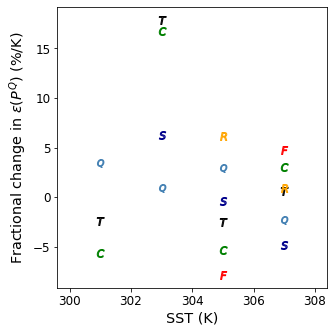

In [49]:

print("Show change in enhancement factors for all pairs of adjacent SSTs at extreme percentiles vs. SST")

ext_lab = 'pr9999'
ef2show = getattr(thismodule,'ef_%s_array'%ext_lab)
# ef2show_all = [getattr(thismodule,'ef_%s_array'%pr_lab) for pr_lab in ['mean_pr','pr999']]
# labels = ['\overline{P}','P^{99.9}']

dSST = 2

fig,ax = plt.subplots(ncols=1,figsize=(5,5))

for i_SST in range(4):
    
    SST = SSTs[i_SST]

    Nc = 0

    for i_ef in range(n_ef):
        
        Nc += 1 # Count to reverse x axis once reach last curve
        
#         if (i_SST,ef_inds[i_ef][0]) in sims2exclude or (i_SST,ef_inds[i_ef][1]) in sims2exclude:
#             print("passing %s"%simname)
# #             print(' passing')
#             continue

        col = SST_col[i_SST]

        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        col = ef_cols[i_ef]
        mw = 1
#         if i_sim == 0:
#             mw = 2

        # x
        x = SST+dSST/2
        
        # y
        ef_cold = ef2show[i_SST,i_ef]
        ef_warm = ef2show[i_SST+1,i_ef]
        y = (ef_warm/ef_cold-1)*100
        
        ax.plot(x,y,marker="$ {} $".format(ef_markers[i_ef]), ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)


# ax.legend(loc='lower left',fontsize=11)
ax.set_xlabel('SST (K)')
ax.set_ylabel(r'Fractional change in $\varepsilon (P^Q)$ (%/K)')
ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

plt.savefig(os.path.join(figuredir,'all','fracchange_ef_%s_vs_SST.pdf'%ext_lab),
            bbox_layout='tight')
plt.show()
    



/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


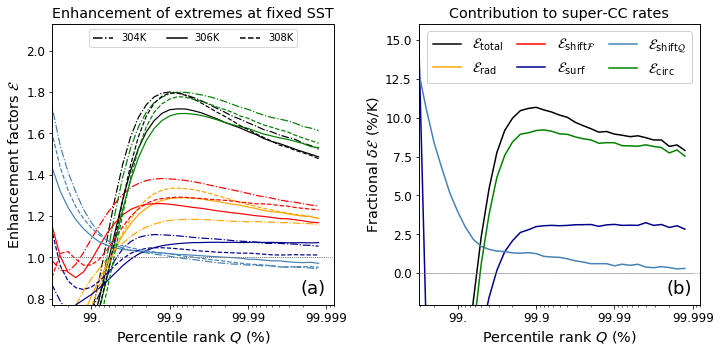

## Contributions to extremes

In [48]:
# contrib = eps_array, intW_array, intMuGamma_array
contrib_name = 'eps','M','Gamma'
contrib_labels = r'Efficiency $\varepsilon$',\
                  r'Effective vertical velocity $\langle w \rangle$ (m/s)',\
                  r'Thermodynamic factor $\langle \frac{w}{\langle w \rangle} \frac{\partial q_v^\star}{\partial z} \rangle$ (kg/m$^3$)'
contrib_col = 'g','b','r'

n_contribs = len(contrib_col)

In [49]:
sQext9999 = slice(iQ9999,iQ99999)

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1


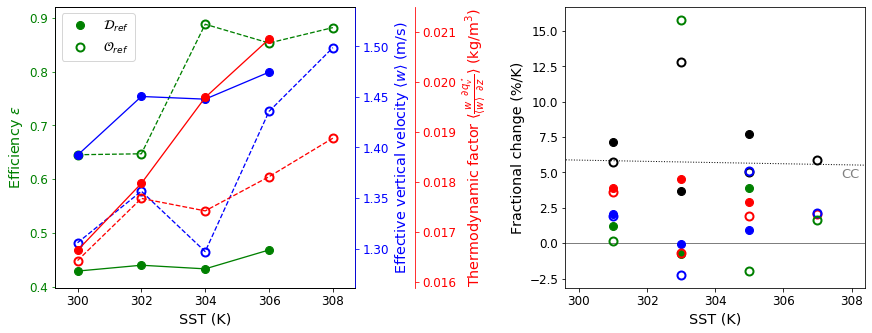

In [394]:

ind_sims2plot = (4,0) # Dref, Oref

# fig, axs = plt.subplots(ncols=2,figsize=(11,5))
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
plt.subplots_adjust(wspace=0.7)

###--- Panel (a) - contributions at fixed SST ---###

# Define axes
ax_0 = axs[0]
ax_eps = ax_0
ax_M = ax_eps.twinx()
ax_Gamma = ax_eps.twinx()
axs_0 = ax_eps,ax_M,ax_Gamma

cont = [np.nan*np.zeros((len(SSTs),len(simname_patterns))),
        np.nan*np.zeros((len(SSTs),len(simname_patterns))),
        np.nan*np.zeros((len(SSTs),len(simname_patterns)))]

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in ind_sims2plot:
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or simname not in scaling.keys():
            print("passing %s"%simname)
            continue
        
        # Show each dot
        for i_con in (2,1,0):
            
            x = SSTs[i_SST]
            cname = contrib_name[i_con]
            y = scaling[simname][cname]
            if cname in ['M','Gamma']:
                y = np.mean(y[sQext9999])
            cont[i_con][i_SST,i_sim] = y
            
            col = contrib_col[i_con]
            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2
            # label
            lab = ''
            if i_con == i_SST == 0:
                lab = simtype_labels[i_sim]
            ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
            ax.plot(x,y,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor=col,
                    markeredgewidth=mw,
                    label=lab)

##--- Draw lines
for i_sim in ind_sims2plot:

    for i_con in (2,1,0):

        # SSTs 
        sst_values = []
        contrib_values = []
        for i_SST in range(n_SSTs):
            
            SST = SSTs[i_SST]
            simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
            
            if not (i_SST,i_sim) in sims2exclude and simname in scaling.keys():
                
                sst_values.append(SST)
                contrib_values.append(cont[i_con][i_SST,i_sim])
                
        sst_values = np.array(sst_values)
        contrib_values = np.array(contrib_values)

        # Get correct axis
        ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
        # Plot
        ax.plot(sst_values,contrib_values,linestyle=simtype_linetype[i_sim],
                linewidth=1.3,c=contrib_col[i_con])

ax.set_xlim((299.3,308.7))
ax.set_xlabel('SST (K)')

contrib_side = 'left','right','right'
for i_con in range(n_contribs):
    
    ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
    col = contrib_col[i_con]
    ax.spines[contrib_side[i_con]].set_color(col)
    ax.tick_params(axis='y', colors=col)
    ax.yaxis.label.set_color(col)
    ax.set_ylabel(contrib_labels[i_con])
    
ax_Gamma.spines["right"].set_position(("axes", 1.2))

ax_0.set_xlabel('SST (K)')
ax_0.legend(loc='best',fontsize=13)

##-- Adjust y-axes ranges
# # Same ratio
# y_shift = (0,0.36,0.27)
# f_ymin = [0.32]*3
# f_ymax = [1.01]*3
# for i in range(3):
#     ax = axs_0[i]
#     ymax = ax.get_ylim()[1]
#     ax.set_ylim((f_ymin[i]*ymax+y_shift[i]*ymax,f_ymax[i]*ymax+y_shift[i]*ymax))

# Different ratio
# f_ymin = (0.95,0.88,0.88)
f_ymin = (0.98,0.98,0.98)
f_ymax = (1.01,1.02,1.02)
for i in range(3):
    ax = axs_0[i]
    ymin,ymax = ax.get_ylim()
    ax.set_ylim((f_ymin[i]*ymin,f_ymax[i]*ymax))

    
###--- Panel (b) - contributions to fractional changes ---###

ax = axs[1]

# Fractional changes in contributions to extremes
cont_fc = [np.log(cont[i_con][1:]/cont[i_con][:-1])/dSST*100 for i_con in range(3)]
sum_fc = cont_fc[0]+cont_fc[1]+cont_fc[2]

##-- zero line
ax.axhline(0,c='k',linestyle='-',linewidth=0.5)

##-- show CC rate
# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
x_CC = x_vals[:-1]
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)
fc_CC = np.log(y_vals_ref[1:]/y_vals_ref[:-1])/dT*100
# plot
ax.plot(x_CC,fc_CC,'k:',linewidth=1)
# ax.text(308, fc_CC-1,'CC')
ax.text(307.7, fc_CC[-1]-0.6, 'CC', va='center',fontsize=13,c='grey')

##-- show contributions
for i_SST in range(n_SSTs-1):

    SST = SSTs[i_SST]
    
    for i_sim in ind_sims2plot:
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or simname not in scaling.keys():
            print("passing %s"%simname)
            continue
        
        x = SSTs[i_SST]+dSST/2
        y_sum = sum_fc[i_SST,i_sim]
        
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = 'k'
        mw = 1
        if i_sim == 0:
            mw = 2
        
        # Fractional change in extremes
        ax.plot(x,y_sum,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor='k',
                    markeredgewidth=mw,
                    label=lab)
        
        # Fractional change in contributions
        for i_con in (2,1,0):
            
            cname = contrib_name[i_con]
            y = cont_fc[i_con][i_SST,i_sim]
            
            col = contrib_col[i_con]
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2
            # label
            lab = ''
            if i_con == i_SST == 0:
                lab = simtype_labels[i_sim]

            ax.plot(x,y,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor=col,
                    markeredgewidth=mw,
                    label=lab)
            

ax.set_xlabel('SST (K)')
ax.set_ylabel(r'Fractional change (%/K)')
ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

    
# plt.savefig(os.path.join(figuredir,'all','eps_intW_intMuGamme_all_SSTs_Oref_Dref.pdf'),
#                 bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','Figure7.pdf'),bbox_inches='tight')
plt.show()

In [395]:
[np.nanmean(cont_fc[i_con],0) for i_con in range(n_contribs)]

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


[array([3.89680513,        nan,        nan,        nan, 1.45671685]),
 array([1.72391622,        nan,        nan,        nan, 0.95531926]),
 array([1.73963944,        nan,        nan,        nan, 3.77929121])]

## Figure 7 - redo with average composites between the 99.99th and 99.999th percentiles

In [396]:
cont_M = np.nan*np.zeros((n_SSTs,n_sims))
cont_Gamma = np.nan*np.zeros((n_SSTs,n_sims))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
#     for i_sim in range(n_sims):
    for i_sim in (0,4):
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or (i_sim == 4 and SST == 308):
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_prof = np.mean(cdist_w[simname].cond_mean[:,sQext9999],axis=1)
        tabs_prof = np.mean(cdist_tabs[simname].cond_mean[:,sQext9999],axis=1)
        
        # Crop input profiles at the tropopause
        p_sc, tabs_sc, w_sc, z_sc = cropProfiles(p_prof, # Pa
                                             tabs_prof,
                                             [w_prof,z_coord.values],
                                             levdim=0)

        # Average mass flux
        cont_M[i_SST,i_sim] = verticalPressureIntegral(p_sc,w_sc) / verticalPressureIntegral(p_sc)

        # Thermodynamic component
        qvstar_sc = saturationSpecificHumidity(tabs_sc,p_sc)
        dqvs_dz = np.diff(qvstar_sc)/np.diff(z_sc)
        cont_Gamma[i_SST,i_sim] = verticalPressureIntegral(p_sc,values=w_sc,dvdp=dqvs_dz)/cont_M[i_SST,i_sim]
        
        
        

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1


passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1


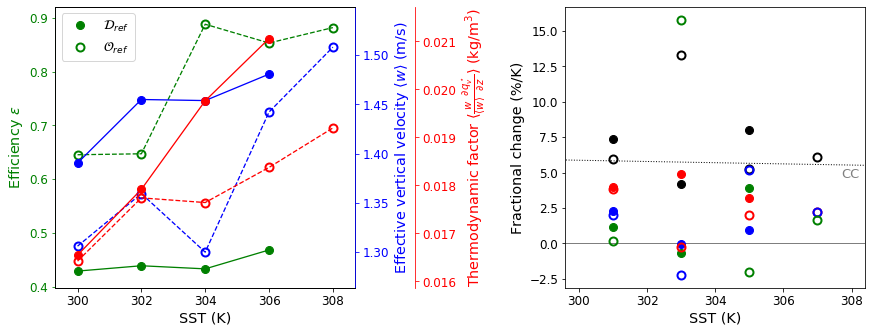

In [397]:

ind_sims2plot = (4,0) # Dref, Oref

# fig, axs = plt.subplots(ncols=2,figsize=(11,5))
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
plt.subplots_adjust(wspace=0.7)

###--- Panel (a) - contributions at fixed SST ---###

# Define axes
ax_0 = axs[0]
ax_eps = ax_0
ax_M = ax_eps.twinx()
ax_Gamma = ax_eps.twinx()
axs_0 = ax_eps,ax_M,ax_Gamma

cont_eps = np.array([[0.6454583 ,        np.nan,        np.nan,        np.nan, 0.4294092 ],
       [0.64723068,        np.nan,        np.nan,        np.nan, 0.43929716],
       [0.88779615,        np.nan,        np.nan,        np.nan, 0.4335327 ],
       [0.85294399,        np.nan,        np.nan,        np.nan, 0.46862989],
       [0.88157053,        np.nan,        np.nan,        np.nan,        np.nan]])

cont = [cont_eps,cont_M,cont_Gamma]

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in ind_sims2plot:
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or simname not in scaling.keys():
            print("passing %s"%simname)
            continue
        
        # Show each dot
        for i_con in (2,1,0):
            
            x = SSTs[i_SST]
            cname = contrib_name[i_con]
            y = cont[i_con][i_SST,i_sim]
            
            col = contrib_col[i_con]
            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2
            # label
            lab = ''
            if i_con == i_SST == 0:
                lab = simtype_labels[i_sim]
            ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
            ax.plot(x,y,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor=col,
                    markeredgewidth=mw,
                    label=lab)

##--- Draw lines
for i_sim in ind_sims2plot:

    for i_con in (2,1,0):

        # SSTs 
        sst_values = []
        contrib_values = []
        for i_SST in range(n_SSTs):
            
            SST = SSTs[i_SST]
            simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
            
            if not (i_SST,i_sim) in sims2exclude and simname in scaling.keys():
                
                sst_values.append(SST)
                contrib_values.append(cont[i_con][i_SST,i_sim])
                
        sst_values = np.array(sst_values)
        contrib_values = np.array(contrib_values)

        # Get correct axis
        ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
        # Plot
        ax.plot(sst_values,contrib_values,linestyle=simtype_linetype[i_sim],
                linewidth=1.3,c=contrib_col[i_con])

ax.set_xlim((299.3,308.7))
ax.set_xlabel('SST (K)')

contrib_side = 'left','right','right'
for i_con in range(n_contribs):
    
    ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
    col = contrib_col[i_con]
    ax.spines[contrib_side[i_con]].set_color(col)
    ax.tick_params(axis='y', colors=col)
    ax.yaxis.label.set_color(col)
    ax.set_ylabel(contrib_labels[i_con])
    
ax_Gamma.spines["right"].set_position(("axes", 1.2))

ax_0.set_xlabel('SST (K)')
ax_0.legend(loc='best',fontsize=13)

##-- Adjust y-axes ranges
# # Same ratio
# y_shift = (0,0.36,0.27)
# f_ymin = [0.32]*3
# f_ymax = [1.01]*3
# for i in range(3):
#     ax = axs_0[i]
#     ymax = ax.get_ylim()[1]
#     ax.set_ylim((f_ymin[i]*ymax+y_shift[i]*ymax,f_ymax[i]*ymax+y_shift[i]*ymax))

# Different ratio
# f_ymin = (0.95,0.88,0.88)
f_ymin = (0.98,0.98,0.98)
f_ymax = (1.01,1.02,1.02)
for i in range(3):
    ax = axs_0[i]
    ymin,ymax = ax.get_ylim()
    ax.set_ylim((f_ymin[i]*ymin,f_ymax[i]*ymax))

    
###--- Panel (b) - contributions to fractional changes ---###

ax = axs[1]

# Fractional changes in contributions to extremes
cont_fc = [np.log(cont[i_con][1:]/cont[i_con][:-1])/dSST*100 for i_con in range(3)]
sum_fc = cont_fc[0]+cont_fc[1]+cont_fc[2]

##-- zero line
ax.axhline(0,c='k',linestyle='-',linewidth=0.5)

##-- show CC rate
# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
x_CC = x_vals[:-1]
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)
fc_CC = np.log(y_vals_ref[1:]/y_vals_ref[:-1])/dT*100
# plot
ax.plot(x_CC,fc_CC,'k:',linewidth=1)
# ax.text(308, fc_CC-1,'CC')
ax.text(307.7, fc_CC[-1]-0.6, 'CC', va='center',fontsize=13,c='grey')

##-- show contributions
for i_SST in range(n_SSTs-1):

    SST = SSTs[i_SST]
    
    for i_sim in ind_sims2plot:
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or simname not in scaling.keys():
            print("passing %s"%simname)
            continue
        
        x = SSTs[i_SST]+dSST/2
        y_sum = sum_fc[i_SST,i_sim]
        
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = 'k'
        mw = 1
        if i_sim == 0:
            mw = 2
        
        # Fractional change in extremes
        ax.plot(x,y_sum,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor='k',
                    markeredgewidth=mw,
                    label=lab)
        
        # Fractional change in contributions
        for i_con in (2,1,0):
            
            cname = contrib_name[i_con]
            y = cont_fc[i_con][i_SST,i_sim]
            
            col = contrib_col[i_con]
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2
            # label
            lab = ''
            if i_con == i_SST == 0:
                lab = simtype_labels[i_sim]

            ax.plot(x,y,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor=col,
                    markeredgewidth=mw,
                    label=lab)
            

ax.set_xlabel('SST (K)')
ax.set_ylabel(r'Fractional change (%/K)')
ax.set_xlim((SSTs[0]-0.4,SSTs[-1]+0.4))

    
# plt.savefig(os.path.join(figuredir,'all','eps_intW_intMuGamme_all_SSTs_Oref_Dref.pdf'),
#                 bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','Figure7.pdf'),bbox_inches='tight')
plt.show()

## Figure 8 - composite profiles and enhancement factors vs. eps and RH

In [327]:
sQext9999 = slice(iQ9999,iQ99999)

In [328]:
print("calculate vertical integral of relative humidity")

p_prof = p_profile['RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1']*100

intRH_array = np.nan*np.zeros((n_SSTs,n_sims))
eps_array = np.nan*np.zeros((n_SSTs,n_sims))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in (0,4):
        
        if (SST == 308 and i_sim == 4):
            continue
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

        # get mean tabs and qv profile across extreme percentile range
        tabs_profiles = cdist_tabs[simname].cond_mean[:,sQext9999]
        tabs_meanprof = np.nanmean(tabs_profiles,axis=1)
        qv_profiles = cdist_qv[simname].cond_mean[:,sQext9999]
        qv_meanprof = np.nanmean(np.vstack(qv_profiles),axis=1)
        p_meanprof = p_prof

        # Crop profiles in troposphere
        pres, tabs, qv = cropProfiles(p_meanprof, # Pa
                                         tabs_meanprof,
                                         [qv_meanprof/1000], # kg/kg
                                         levdim=0)
        qvstar_tabs = saturationSpecificHumidity(tabs,pres)
        relhum = qv/qvstar_tabs*100
#         print(relhum)

        # pressure-weighted vertical integral of RH
        intRH = verticalPressureIntegral(pres,relhum)/verticalPressureIntegral(pres)

        # store
        intRH_array[i_SST,i_sim] = intRH
        eps_array[i_SST,i_sim] = scaling[simname]['eps']

calculate vertical integral of relative humidity


In [329]:
# compute enhancement of each component in comparison with Dref
for key in 'eps_array','intRH_array':
    
    array = getattr(thismodule,key)
    ef_array = computeEnhancementFactors(array)
    setattr(thismodule,"ef_%s"%key,ef_array)
    
    print()
    print('--------------- %s -----------------'%key)
    printEFArrayAsLatexTable(ef_array)


--------------- eps_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &   4 &   5 \\
\midrule
300 K & 1.50 &    - &    - &    - & nan & nan \\
302 K & 1.47 &    - &    - &  NaN & nan & nan \\
304 K & 2.05 &  NaN &  NaN &  NaN & nan & nan \\
306 K & 1.82 &  NaN &  NaN &  NaN & nan & nan \\
308 K &  nan &  NaN &  NaN &  NaN & nan & nan \\
\bottomrule
\end{tabular}


--------------- intRH_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &   4 &   5 \\
\midrule
300 K & 1.19 &    - &    - &    - & nan & nan \\
302 K & 1.18 &    - &    - &  NaN & nan & nan \\
304 K & 1.27 &  NaN &  NaN &  NaN & nan & nan \\
306 K & 1.25 &  NaN &  NaN &  NaN & nan & nan \\
308 K &  nan &  NaN &  NaN &  NaN & nan & nan \\
\bottomrule
\end{tabular}



Combined figure with RH and W profiles and correlations

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1
iplot = 0
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
iplot = 1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1M

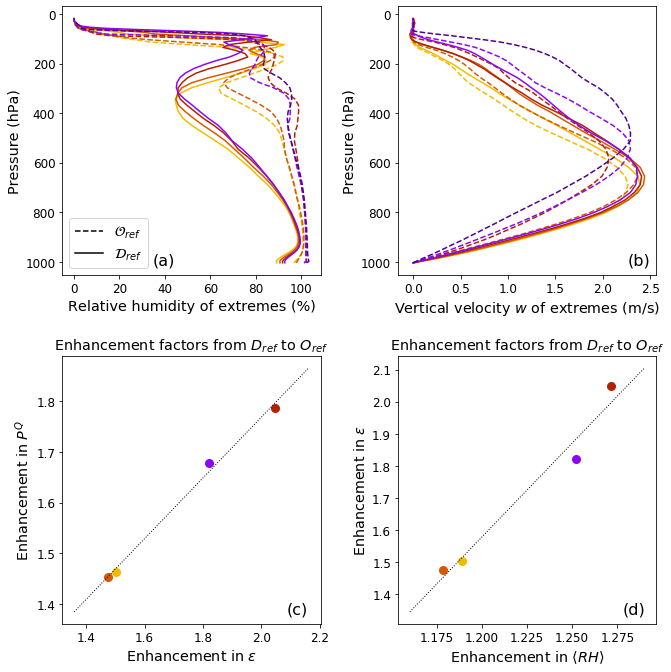

In [347]:
print("Combined figure with RH and W profiles and correlations")
print()


p_prof = p_profile['RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1']*100

fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(11,11))

#####----------- Panels (a) and (b), vertical profiles of RH and W --------------#####
axs_profiles = axs[0]

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
#     for i_sim in range(n_sims):
    for i_sim in (0,4):
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        if (i_SST,i_sim) in sims2exclude or (i_sim == 4 and SST == 308):
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_all = []
        qvstar_all = []
        relhum_all = []
        for iQ in range(iQ9999,iQ99999):
            # vertical velocity
            w_all.append(cdist_w[simname].cond_mean[:,iQ])
            # thermodynamic profiles
            tabs_prof = cdist_tabs[simname].cond_mean[:,iQ]
            qv_prof = cdist_qv[simname].cond_mean[:,iQ]/1000 ### STOPPED HERE
            qvstar_prof = saturationSpecificHumidity(pres=p_prof,temp=tabs_prof)
            qvstar_all.append(qvstar_prof)
            relhum_prof = qv_prof/qvstar_prof*100
            relhum_all.append(relhum_prof)
        # compute mean profiles across percentiles
        w = np.nanmean(np.vstack(w_all),axis=0)
        qvstar = np.nanmean(np.vstack(qvstar_all),axis=0)
        relhum = np.nanmean(np.vstack(relhum_all),axis=0)
        
        pres = p_prof

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        # label
        lab = ''
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        # Panel (a) - profiles of RH for reference runs
        if i_sim in (0,4):
            axs_profiles[0].plot(relhum,pres/100,c=col,linestyle=simtype_linetype[i_sim],label=lab)
            axs_profiles[1].plot(w,pres/100,c=col,linestyle=simtype_linetype[i_sim])

for ax in axs_profiles:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (hPa)')

axs_profiles[0].set_xlabel(r'Relative humidity of extremes (%)')
# axs_profiles[1].set_xlabel(r'Vertical velocity $w$ for $P\in [P^{99.99},P^{99.999}]$ (m/s)')
axs_profiles[1].set_xlabel(r'Vertical velocity $w$ of extremes (m/s)')


# Legend
custom_lines = [Line2D([0], [0], color='k',linestyle=simtype_linetype[0]),
                Line2D([0], [0], color='k',linestyle=simtype_linetype[4])]

# axs_profiles[0].legend(fontsize=14) # Default legend
axs_profiles[0].legend(custom_lines,[simtype_labels[0],simtype_labels[4]],fontsize=14)


#####----------- Panels (c) and (d), correlations --------------#####
axs_corr = axs[1]

ef_markers = "T","R","F","S","Q","C"

predictors = ef_eps_array, ef_intRH_array, ef_prQext_array
predictors_labels = r'$\varepsilon$', r'$\langle RH \rangle$', r'$P^Q$'
predictors_names = 'eps','intRH','prQ'

# prQ vs eps
i_pred_x_s = 0,1
i_pred_y_s = 2,0

for i_plot,ax in zip(range(2),axs_corr):

    print('iplot =',i_plot)

    i_pred_x = i_pred_x_s[i_plot]
    i_pred_y = i_pred_y_s[i_plot]

    # Store values
    x_all = []
    y_all = []

    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_ef in range(n_ef):

            simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

    #         print(simname)
            if (i_SST,ef_inds[i_ef][0]) in sims2exclude or (i_SST,ef_inds[i_ef][1]) in sims2exclude:
                print("passing %s"%simname)
    #             print(' passing')
                continue


            x = predictors[i_pred_x][i_SST,i_ef]
            y = predictors[i_pred_y][i_SST,i_ef]
            x_all.append(x)
            y_all.append(y)

            col = SST_col[i_SST]
#             col = 'k'
            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2

    #         ax.plot(x,y,ef_markers[i_ef], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
#             ax.scatter(x,y,marker="$ {} $".format(ef_markers[i_ef]), c=[col],s=100)
            ax.plot(x,y,marker=simtype_markers[4],ms=8,
                            markerfacecolor=mfc,
                            markeredgecolor=col,
                            markeredgewidth=mw)

    # compute range of values to plot for regression line
    fac = 0.2
    x_range = np.nanmin(x_all),np.nanmax(x_all)
    dxrange = x_range[1] - x_range[0]
    x_range2plot = x_range[0]-fac*dxrange, x_range[1]+fac*dxrange
    
    # remove nans
    x_all, y_all = np.array(x_all),np.array(y_all)
    mask_regress = np.logical_not(np.logical_or(np.isnan(x_all),np.isnan(y_all)))
    # regress
    x_regress, y_regress = x_all[mask_regress],y_all[mask_regress]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_regress,y_regress)
    
    x = np.arange(x_range2plot[0],x_range2plot[1],0.001)
    y = intercept + slope*x
    ax.plot(x,y,'k:',linewidth=1)
#     ax.text(0.4,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

#     # Color bar
#     cax, _ = matplotlib.colorbar.make_axes(ax)
#     normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
#     cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

    # ax.set_xlabel(r'Enhancement in saturation deficit $\langle 1-RH \rangle$')
    ax.set_xlabel(r'Enhancement in %s'%(predictors_labels[i_pred_x]))
    ax.set_ylabel(r'Enhancement in %s'%(predictors_labels[i_pred_y]))
    ax.set_title(r'Enhancement factors from $D_{ref}$ to $O_{ref}$')

##-- panel numbers
axs[0,0].text(0.35,0.04,'(a)',transform = axs[0,0].transAxes,fontsize=16)
axs[0,1].text(0.89,0.04,'(b)',transform = axs[0,1].transAxes,fontsize=16)
axs[1,0].text(0.87,0.04,'(c)',transform = axs[1,0].transAxes,fontsize=16)
axs[1,1].text(0.87,0.04,'(d)',transform = axs[1,1].transAxes,fontsize=16)

# plt.savefig(os.path.join(figuredir,'profiles_RH_w_and_corr_prQ_eps_intRH.pdf'),
#                 bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','Figure8.pdf'),bbox_inches='tight')

plt.show()

In [336]:
x_range2plot

(1.1508163857546154, 1.299465787859924)

# Supplementary figures

## Fig S1 - timeseries of PW or Prec to show convergence / oscillations in organized regimes

In [26]:
L_v, 2.5104e+06,ndays

(2260000.0, 2510400.0, 50)

In [10]:
print("Compare LHF and L*P in organized and disorganized runs")

i_sim = 0
print('sim:%s'%simname_patterns[i_sim])

for SST in SSTs:
    sim = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    print('LHF =',np.mean(data_mean_t[sim].LHF[-ndays*24:]).values)
    print('LHF/P =',np.mean(data_mean_t[sim].LHF[-ndays*24:]).values/np.mean(data_mean_t[sim].Prec[-ndays*24:]).values)

Compare LHF and L*P in organized and disorganized runs
sim:RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d
LHF = 112.39142
LHF/P = 28.905258
LHF = 118.12586
LHF/P = 28.683706
LHF = 138.19537
LHF/P = 29.16725
LHF = 139.17856
LHF/P = 29.754267
LHF = 147.6271
LHF/P = 28.593779


simulation pattern: RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r%d


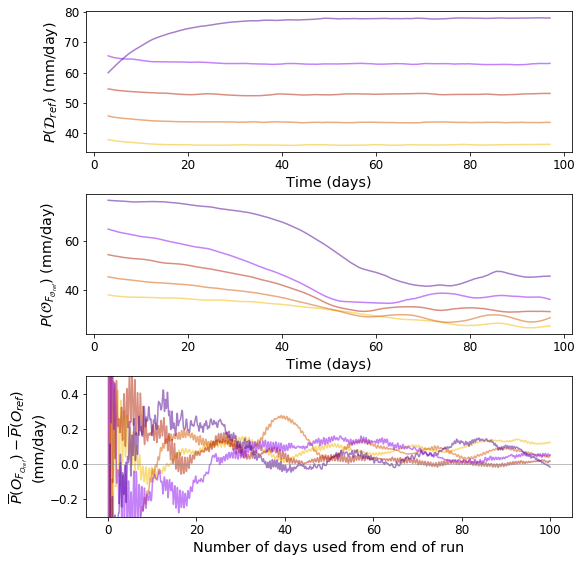

In [16]:

print('simulation pattern: %s'%simname_patterns[i_sim])
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# varid = 'Prec'
varid = 'PW'

# Nhrs = 48
Nhrs = 72
fig, axs = plt.subplots(nrows=3,figsize=(9,9))

# Dref
i_sim = 4 # reference organized
ax = axs[0]

for i_SST in range(len(SSTs)):

    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])

    data = data_mean_t[simname]
    s_filt = slice(Nhrs,24*min(100,len(data.time)/24)-Nhrs)
    x = data.time[s_filt]
    y = np.convolve(data[varid],np.ones(Nhrs)/Nhrs,'same')[s_filt]
    ax.plot(x,y,c=SST_col[i_SST],alpha=0.5)
    
ax.set_ylabel(r'$P(\mathcal{D}_{ref})$ (mm/day)')
ax.set_xlabel('Time (days)')

# Oref
i_sim = 0 # reference organized
ax = axs[1]

for i_SST in range(len(SSTs)):

    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    
    data = data_mean_t[simname]
    s_filt = slice(Nhrs,24*min(100,len(data.time)/24)-Nhrs)
    x = data.time[s_filt]
    y = np.convolve(data[varid],np.ones(Nhrs)/Nhrs,'same')[s_filt]
    ax.plot(x,y,c=SST_col[i_SST],alpha=0.5)

ax.set_ylabel(r'$P(\mathcal{O}_{F_{\mathcal{O}_{ref}}})$ (mm/day)')
ax.set_xlabel('Time (days)')

# Error between Oref and O(F_Oref)
ax = axs[2]
i_sim_agg = 0
i_sim_sfcagg = 1

varid = 'Prec'
s = slice(0,100*24)

for i_SST in range(len(SSTs)):
    
    SST = SSTs[i_SST]
    simname_agg = simname_patterns[i_sim_agg]%(SST,realiz[SST][i_sim_agg])
    simname_sfcagg = simname_patterns[i_sim_sfcagg]%(SST,realiz[SST][i_sim_sfcagg])
    
    data_agg = data_mean_t[simname_agg]
    data_sfcagg = data_mean_t[simname_sfcagg]
    pr_sfcagg = np.cumsum(np.flipud(data_agg[varid]))[s]/range(1,len(data_agg.time)+1)[s]
    pr_agg = np.cumsum(np.flipud(data_sfcagg[varid]))[s]/range(1,len(data_sfcagg.time)+1)[s]
    
    # plot
    ax.plot(data_agg.time[s],pr_agg-pr_sfcagg,c=SST_col[i_SST],alpha=0.5)
    
ax.axhline(y=0,c='grey',linewidth=0.5)
ax.set_xlabel('Number of days used from end of run')
ax.set_ylabel(r'$\overline{P}(O_{F_{O_{ref}}})-\overline{P}(O_{ref})$'+'\n(mm/day)')
ax.set_ylim((-.3,.5))


plt.savefig(os.path.join(figuredir,'all','timeseries_%s_filtered%dh_%d.pdf'%(varid,Nhrs,i_sim)),
           bbox_inches='tight')
# plt.savefig(os.path.join(figuredir,'paper','FigureS1.pdf'),bbox_inches='tight')

Text(0, 0.5, 'Mean P (mm/day)')

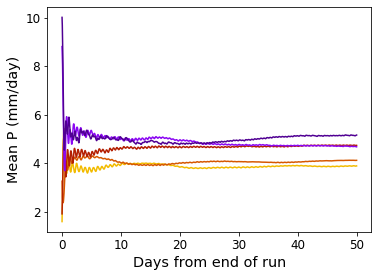

In [33]:
i_sim = 0 # reference organized
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

varid = 'Prec'
s = slice(None,50*24)

fig, ax = plt.subplots()
for i_SST in range(len(SSTs)):
    
    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    
    data = data_mean_t[simname]
    ax.plot(data.time[s],np.cumsum(np.flipud(data[varid]))[s]/range(1,len(data.time)+1)[s],c=SST_col[i_SST])
    
ax.set_xlabel('Days from end of run')
ax.set_ylabel('Mean P (mm/day)')

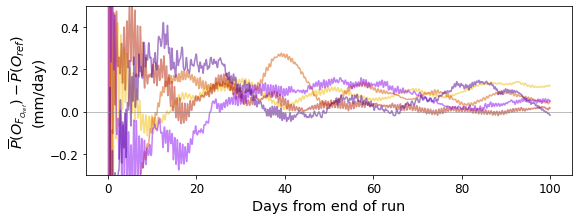

In [82]:
i_sim_agg = 0 # reference organized
i_sim_sfcagg = 1
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

varid = 'Prec'
s = slice(0,100*24)

fig, ax = plt.subplots(figsize=(9,3))
for i_SST in range(len(SSTs)):
    
    SST = SSTs[i_SST]
    simname_agg = simname_patterns[i_sim_agg]%(SST,realiz[SST][i_sim_agg])
    simname_sfcagg = simname_patterns[i_sim_sfcagg]%(SST,realiz[SST][i_sim_sfcagg])
    
    data_agg = data_mean_t[simname_agg]
    data_sfcagg = data_mean_t[simname_sfcagg]
    pr_sfcagg = np.cumsum(np.flipud(data_agg[varid]))[s]/range(1,len(data_agg.time)+1)[s]
    pr_agg = np.cumsum(np.flipud(data_sfcagg[varid]))[s]/range(1,len(data_sfcagg.time)+1)[s]
    
    # plot
    ax.plot(data_agg.time[s],pr_agg-pr_sfcagg,c=SST_col[i_SST],alpha=0.5)
    
ax.axhline(y=0,c='grey',linewidth=0.5)
ax.set_xlabel('Days from end of run')
ax.set_ylabel(r'$\overline{P}(O_{F_{O_{ref}}})-\overline{P}(O_{ref})$'+'\n(mm/day)')
ax.set_ylim((-.3,.5))

plt.savefig(os.path.join(figuredir,'FigureS2.pdf'),bbox_inches='tight')
plt.show()

In [10]:
print('Is there any error in the calculation of mean rainfall?')

for i_sim in range(n_sims):
    
    for i_SST in range(len(SSTs)):

        SST = SSTs[i_SST]
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        
        err = (pr_mean[simname]/mean_pr[simname]-1)*100
        print(". %s error: %2.6f"%(simname,err))
print('nope')

Is there any error in the calculation of mean rainfall?
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1 error: 0.000282
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2 error: 0.000336
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1 error: 0.000594
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1 error: 0.000540
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r2 error: 0.000471
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg error: 0.000084
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcagg error: 0.000184
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcagg error: 0.000840
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1-b150-sfcagg error: 0.000829
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r1-b150-sfcagg error: 0.000772
. RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_T

## Fig S2 - LHF, SHF, int Qrad vs. SST

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
passing RCE_MPDATAx

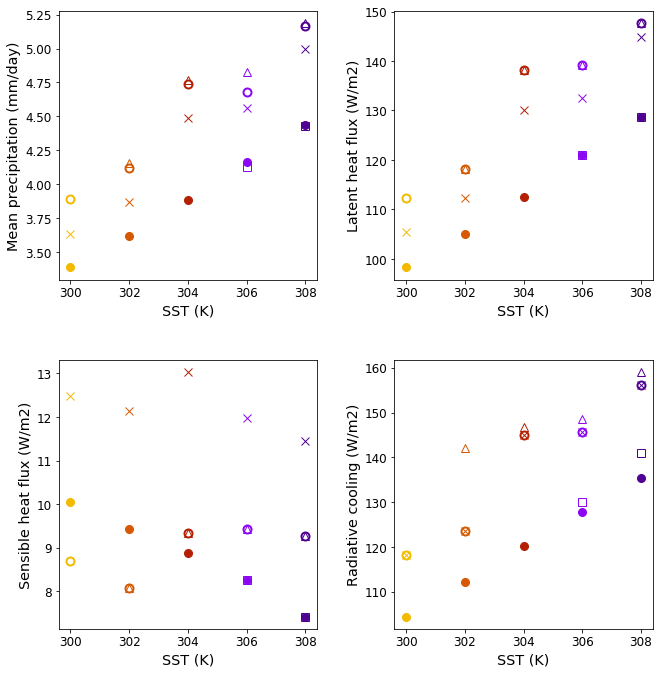

In [149]:
simtype_col = 'k','b','r','g','k'

# Var to plot
varids = 'Prec','LHF','SHF','QRAD'
varlabels = 'Mean precipitation','Latent heat flux','Sensible heat flux','Radiative cooling'

# N days for averaging
ndays = 50

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(11,11))

for i_var,ax in zip(range(len(varids)),axs.flatten()):
    
    varid = varids[i_var]
    
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_sim in range(n_sims):

            #- pick simulation
            
            i_sim_values = i_sim
            
            if varid in ['LHF','SHF']: # then pick data from forcing simulations

                if i_sim == 1: # sfcagg
                    i_sim_values = 0
                elif i_sim == 2: # sfcdisagg
                    i_sim_values = 4
            
            elif varid == 'QRAD':
                
                if i_sim == 3: # radagg
                    i_sim_values = 0
            
            simname = simname_patterns[i_sim_values]%(SST,realiz[SST][i_sim_values])

            #- remove discarded simulations
            
            if (i_SST,i_sim) in sims2exclude:
                print("passing %s"%simname)
                continue

            # Show
                
            if simname in data_mean_t.keys():
                
                col = SST_col[i_SST]

                # Show points
                if i_sim in (0,1,2):
                    mfc = 'none'
                else:
                    mfc = col
                mw = 1
                if i_sim == 0:
                    mw = 2
                
                #- values to show
                x = SST
                
                if varid == 'QRAD':
                    lwc = data_mean_t[simname]['LWNT'][-ndays*24:] - data_mean_t[simname]['LWNS'][-ndays*24:]
                    swa = data_mean_t[simname]['SWNT'][-ndays*24:] - data_mean_t[simname]['SWNS'][-ndays*24:]
                    qrad = lwc - swa
                    y = np.mean(qrad)
                else:
                    y = np.mean(data_mean_t[simname][varid][-ndays*24:])
                
                #- show
                ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)

    ax.set_xlabel('SST (K)')
    if varid == 'QRAD':
        ax.set_ylabel(r'Radiative cooling (W/m2)')
    else:
        ax.set_ylabel(r'%s (%s)'%(varlabels[i_var],data_mean_t[simname][varid].units))
        

# # Color bar
# cax, _ = matplotlib.colorbar.make_axes(ax)
# normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
# cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.savefig(os.path.join(figuredir,'paper','FigureS2.pdf'),bbox_inches='tight')
plt.show()

## Figure S3 - 99.9th percentile vs. SST

No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.05893
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
0.05893
0.05805
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2-b150-sfcdisagg
0.05805
0.05719
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
0.05719
0.05634
0.05634
0.05551
0.05551


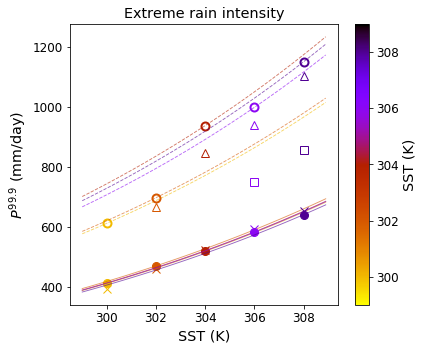

In [94]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# iQext = iQref + 10
iQext = iQref

def getExponentialSSTCurve(i_sim,slopes,offsets,iQ=None):

    simtype = simtypes[i_sim]
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:
            sst_values.append(SSTs[i_SST])
    sst_values = np.array(sst_values)
    # curve points
    x = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
    if iQ is None:
        y = np.exp(slopes[simtype]*x + offsets[simtype])
    else:
        y = np.exp(slopes[simtype][iQ]*x + offsets[simtype][iQ])
    
    return x,y
    
# legend font size
ftsize = 12
# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6.2,5))
# ax.set_ylim((450,1850))

##--- Draw exponential fits
for i_sim in range(n_sims):

    simtype = simtypes[i_sim]

    continue
    
    if i_sim in (0,4):

#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

        # SSTs 
        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%(SSTs[i_SST],realiz[SSTs[i_SST]][i_sim])
                
                # extreme P
#                 pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
#                 pr_values.append(np.mean(distributions[simname].percentiles[sQext]))
                # 99.9th percentile
                pr_values.append(distributions[simname].percentiles[iQext])
                
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        print(pr_values)
        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

        
##--- Draw points and CC curves
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in distributions.keys():

            # Mean over percentiles
#             x,y = SST,np.mean(perc_ILQ_pr[simname][sQext])
#             x,y = SST,np.mean(distributions[simname].percentiles[sQext])
            # Reference 99.9th percentile
#             x,y = SST,perc_ILQ_pr[simname][iQref]
            x,y = SST,distributions[simname].percentiles[iQext]
            
#             #--- Draw error bar
#             if i_sim in (0,4):
#                 y1 = distributions[simname].percentiles_Q1[iQext]
#                 y2 = distributions[simname].percentiles_Q3[iQext]
#                 ax.plot([x,x],[y1,y2],c=SST_col[i_SST])
        
            #--- Draw CC curve
            if i_sim in (0,4):
                # Assuming a fixed rate
    #             y_vals = y_vals_norm*y*np.exp(-rate*x)

                # Assuming the CC formula
                i_x = np.argmin(np.abs(x_vals - float(SST)))
                y_vals = y_vals_ref/y_vals_ref[i_x]*y
                print("%2.5f"%((np.diff(y_vals)[i_x]/y_vals[i_x])/dT))

                ax.plot(x_vals,y_vals,linestyle=simtype_linetype[i_sim],\
                        c=SST_col[i_SST],linewidth=0.9,alpha=0.6)
                
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
#                 lab = simtype_labels[i_sim]
                lab = ''
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)


ax.legend(fontsize=ftsize,framealpha=0)
ax.set_xlabel('SST (K)')
ax.set_ylabel(r'$P^{%2s}$ (mm/day)'%str(ranks[iQext]))
ax.set_title(r'Extreme rain intensity')


# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')


# axs[1].legend(ncol=2,fontsize=11)
ax.legend(ncol=1,fontsize=ftsize,framealpha=0)

plt.savefig(os.path.join(figuredir,'all','P%s_vs_SST_allsims.pdf'%str(ranks[iQext]).replace('.','')[:5]),
                bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','FigureS3.pdf'),
                bbox_inches='tight')
plt.show()

## Figure S3 - PQ vs. Q with scaling approximation at all SSTs

RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-radhomo-r1


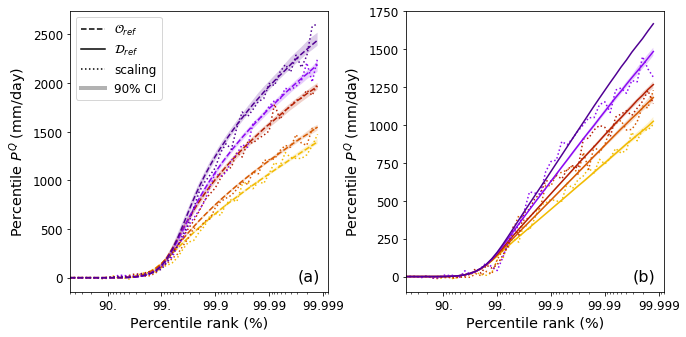

In [404]:
lt = ['--','-']

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(11,5))

SST_inds = range(5)
# SSTs2plot = SSTs[SST_inds[0]],SSTs[SST_inds[1]]
sim_inds = np.array((0,4))

# ranks2show = ranks_9999
# sQ2show = sQ9999
ranks2show = ranks_99999
sQ2show = sQ99999
iQshow_max = 99.999
    
for ax,i_sim in zip(axs,sim_inds):
    
    for i_SST in SST_inds:
        
        SST = SSTs[i_SST]
    
        simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
        simlab = simtype_labels[i_sim]+', %dK'%SST
        print(simname)

#         cdf_invlog = pr_mean[simname]*cdf_invlog_ILQ_pr[simname]
#         invCDF_show = mean_pr[simname]*distributions[simname].invCDF[sQ2show]
        perc_show = distributions[simname].percentiles[sQ2show]
        if simname in scaling.keys():
            perc_range = [distributions[simname].percentiles_P5[sQ2show],
                          distributions[simname].percentiles_P95[sQ2show]]
        else:
            perc_range = [perc_show,perc_show]
            
        # shading
        subplotYShadingRanksILog(ax,ranks2show,
                                 perc_range,
                                 col=SST_col[i_SST],
                                 alpha=0.2,
                                 transformX=False)
        
        # percentiles
        subplotRanksILog(ax,ranks2show,
                         perc_show,
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)
        
        # scaling
        if simname in scaling.keys():
            subplotRanksILog(ax,ranks2show,
                         scaling[simname]['OGS09'][sQ2show]*86400,
                         col=SST_col[i_SST],
                         ltype=':',
                         transformX=False)


#     key = "%s_%s"%(simname_patterns[i_sim]%(SSTs2plot[0],realiz[SSTs2plot[0]][i_sim]),
#                    simname_patterns[i_sim]%(SSTs2plot[1],realiz[SSTs2plot[1]][i_sim]))
#     keylabel = simtype_labels[i_sim]+r", %dK $\rightarrow$ %dK"%tuple(SSTs2plot)


x = np.flipud(1./(1-ranks2show/100.))
# Deal with np.nans at the beginning of panel (d)
# addYLine(axs[0],x,y0=-35)

for ax in axs.flatten():
    # add legend
#     ax.legend(fontsize=11)
    # add x labels
    ax.set_xlabel('Percentile rank (%)')
#     # transform x axis
#     transformXaxisIL(ax,x,offset=0)
#     # crop axis
#     iQ_min = 4
# #     iQ_min = 14
#     ax.set_xlim((x[iQ_min-1],0.8))

    ax.invert_xaxis()
    iQ_min = 4
    ax.set_xlim((x[iQ_min-1],0.8))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    n = ceil(log10(x.max()))
    offset = 1
    N = len(labels)
    for i in range(1,N):
        labels[-n+i-4+offset] = ("%2.7f"%(100*(1-10**(-n+i-1)))).rstrip('0')
        if -n+i-1 == 0:
            break
    ax.set_xticklabels(labels)

    
axs[1].set_ylabel(r'Percentile $P^Q$ (mm/day)')
axs[0].set_ylabel(r'Percentile $P^Q$ (mm/day)')

##-- Panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=16)

##-- Additional legend
custom_lines = [Line2D([0], [0], color='k',linestyle=simtype_linetype[0]),
                Line2D([0], [0], color='k',linestyle=simtype_linetype[4]),
                Line2D([0], [0], color='k',linestyle=':'),
                Line2D([0], [0], color='k',linewidth=4,alpha=0.3)]

# axs_profiles[0].legend(fontsize=14) # Default legend
axs[0].legend(custom_lines,[simtype_labels[0],simtype_labels[4],'scaling','90% CI'],fontsize=12)


# plt.savefig(os.path.join(figuredir,'all','Figure3_distributions_org_disorg_%d_%d.pdf'%tuple(SSTs2plot)),
#                 bbox_inches='tight')
plt.savefig(os.path.join(figuredir,'paper','FigureS4.pdf'),
                bbox_inches='tight')
plt.show()


In [41]:
print('precipitation efficiency values:')
for simname in scaling.keys():
    print(simname, 'eps = %1.3f'%scaling[simname]['eps'])

precipitation efficiency values:
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r2 eps = 0.882
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1 eps = 0.645
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2 eps = 0.647
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r2 eps = 0.439
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1 eps = 0.888
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1 eps = 0.853
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-radhomo-r1 eps = 0.469


## Figure S4 - Fractional changes of M, Gamma, epsilon for adjacent pairs of SSTs

## Figure S5 - Another illustration of enhancement factors on the bottom path, for the unevenness of precipitation (fractional change in amount fraction)

In [15]:
simname_patterns

('RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcdisagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1-b100-radagg',
 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1')

Show amount fraction for all runs at all SSTs


TypeError: not enough arguments for format string

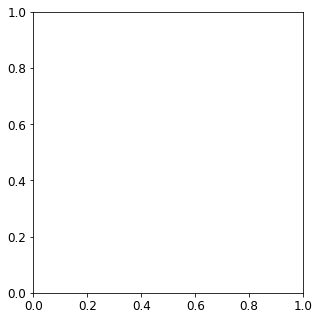

In [154]:
print("Show amount fraction for all runs at all SSTs")

lt = ['--','--','--','-','-']
col = ['k','r','y','deepskyblue','k']

s = sQ
Nc = 0
for i_SST in range(5):
    
    SST = SSTs[i_SST]
    
    fig,ax = plt.subplots(ncols=1,figsize=(5,5))
    # ax.set_ylim((-0.2,25.2))

    for i_sim in range(5):
        
        Nc += 1 # Count to reverse x axis once reach last curve
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        simname = simname_patterns[i_sim]%SST

        cdf_invlog = cdf_invlog_ILQ_pr[simname]*100

        subplotRanksILog(ax,ranks_9999,
                         cdf_invlog[sQ9999],
                         col=col[i_sim],
                         ltype=lt[i_sim],
                         labels=simtype_labels[i_sim],
                         transformX=Nc==5)

    ax.legend(loc='lower left',fontsize=11)
    ax.set_xlabel('Percentile rank Q (%)')
    ax.set_ylabel(r'Rain mass fraction above $P^Q$ (%)')
    ax.set_title('%d K'%SST)
    
    Nc = 0

#     plt.savefig(os.path.join(figuredir,'cdf_invlog_%d.pdf'%SST),
#                 bbox_layout='tight')
    plt.show()
    


## Vertical velocity profiles with error range

RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r2
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST308-r2


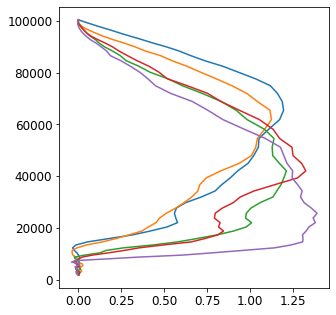

In [353]:

i_sim = 0
iQ = iQ999

fig,ax = plt.subplots(figsize=(5,5))

for i_SST in SST_inds:

    SST = SSTs[i_SST]
    simname = simname_patterns[i_sim]%(SST,realiz[SST][i_sim])
    print(simname)
    
#     x_mean = prQ_prof_conditionals[simname]['W'][iQ]
    y = p_prof
#     ax.plot(x_mean,y)
    ax.plot(cdist_w[simname].cond_mean[:,iQ],y)
    
